In [27]:
import math
import matplotlib.pyplot as plt
import numpy as np

### Resources that were useful in putting this together:
EE image to np array: [Link](https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn/351177#351177)

Steps:
- get scene that intersects with ROI
- filter for dates, clouds, select bands
- get numpy from EE image for each band

## Connect to EE

In [1]:
import ee

# authenticating a GCloud service account (id, privatekey)
service_id = 'ee-access@goldbusters-data-load.iam.gserviceaccount.com'
service_privatekey = 'goldbusters-data-load-privatekey.json'
credentials = ee.ServiceAccountCredentials(service_id, service_privatekey)
ee.Initialize(credentials)

## TEST: plot numpy from image
source :
https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn/351177#351177

(373, 531)
(373, 531)
(373, 531)
(373, 531, 3)


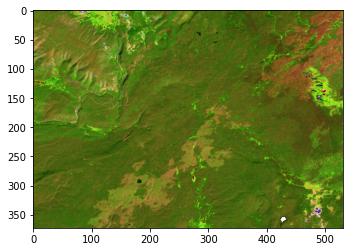

In [59]:
# Define an image.
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B4')
band_arr_b5 = band_arrs.get('B5')
band_arr_b6 = band_arrs.get('B6')

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.dstack((np_arr_b6, np_arr_b5, np_arr_b4)) 
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

## Get region around point of interest
this is used to filter scenes from Sentinel-2: we only keep scenes that intersect 100% with the region of interest

In [20]:
center = (-78.614217766, -0.827621582972643)
radius_ROI = 700 # 1.4km by 1.4km

# get region from center + radius + rectangle
ROI = ee.Geometry.Point(center).buffer(radius_ROI).bounds()

In [52]:
ROI = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

## Get collection, filter for dates and cloud coverage

In [53]:
# dataset and bands
scene = ( ee.ImageCollection('COPERNICUS/S2_SR')
        .select(['B4', 'B3', 'B2']) # bands
        .filterBounds(ROI)
        .filter(ee.Filter.date('2017-04-01', '2017-09-02')) # dates
        .sort('CLOUD_COVER')        # cloud coverage (asc)
        .first() )                  # pick the one with lowest cloud coverage (clearest)

In [54]:
type(scene.divide(10000).sampleRectangle(ROI))

ee.feature.Feature

In [42]:
# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
patch = scene.divide(10000).sampleRectangle(ROI)
features = patch.getInfo()

EEException: Image.divide: Parameter 'image1' is required.

## Crop scene to ROI

In [33]:
scene.divide(100000)

In [23]:
scene